In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from matplotlib.pyplot import *

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
df = pd.read_excel('data_heart_disease.xlsx')

In [3]:
#Podział danych na część uczącą i testową (80:20)
df_learn = df.iloc[:int(0.8*len(df)),:]
df_test = df.iloc[int(0.8*len(df)):,:]

In [4]:
X = np.array([df_learn.HighBP,df_learn.HighChol,df_learn.CholCheck,df_learn.BMI,df_learn.Smoker,df_learn.Stroke,df_learn.Diabetes,df_learn.PhysActivity,df_learn.Fruits,df_learn.Veggies,df_learn.HvyAlcoholConsump,df_learn.DiffWalk,df_learn.Sex,df_learn.Age]).transpose()

df_learn_y = pd.DataFrame(df_learn.HeartDiseaseorAttack)
y = np.array(df_learn_y)

X = X/np.amax(X, axis=0)

In [5]:
test_X = np.array([df_test.HighBP,df_test.HighChol,df_test.CholCheck,df_test.BMI,df_test.Smoker,df_test.Stroke,df_test.Diabetes,df_test.PhysActivity,df_test.Fruits,df_test.Veggies,df_test.HvyAlcoholConsump,df_test.DiffWalk,df_test.Sex,df_test.Age]).transpose()

df_test_y = pd.DataFrame(df_test.HeartDiseaseorAttack)
test_y = np.array(df_test_y)

test_X = test_X/np.amax(test_X, axis=0)

In [6]:
#New complete class, with changes:
class Neural_Network(object):
    def __init__(self, Lambda=0):
        #Define Hyperparameters
        self.inputLayerSize = 14
        self.outputLayerSize = 1
        self.hiddenLayerSize = 8

        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)

        #Regularization Parameter:
        self.Lambda = Lambda

    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3)
        return yHat

    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))

    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)

    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J

    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)

        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2

        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1

        return dJdW1, dJdW2

    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params

    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end],
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end],
                             (self.hiddenLayerSize, self.outputLayerSize))

    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))


In [7]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N

    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))

    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)

        return cost, grad

    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY

        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []

        params0 = self.N.getParams()

        options = {'maxiter': 800, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [8]:
NN = Neural_Network()

In [9]:
T = trainer(NN)

In [10]:
T.train(X, y, test_X, test_y)

Optimization terminated successfully.
         Current function value: 0.036135
         Iterations: 306
         Function evaluations: 310
         Gradient evaluations: 310


Text(0, 0.5, 'Cost')

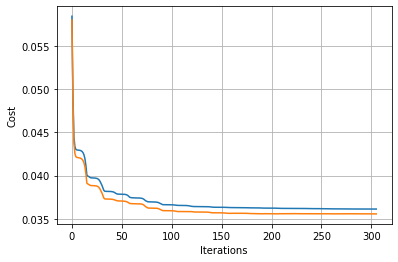

In [11]:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

In [12]:
NN.forward(X)

array([[0.22381086],
       [0.00675536],
       [0.15742625],
       ...,
       [0.00213949],
       [0.00175088],
       [0.00173077]])

In [13]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])